<img src=https://api-manager.universia.net/coreplatform-document-management/api/document-management/public/6ra7ymjkfi64845 width="300" align="left">
<br />

# Aprendizaje automático I
#### <font color=green>*Máster en Informática Industrial y Robótica*</font>

Daniel Vidal Soroa  
Juan Diego Peña 

## Clasificación de mangos en tres clases según su presencia para la exportación, comercio local o procesamiento industrial

#### Importación de las librerías:

In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix, classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
from tensorflow import keras
from keras import layers, models, utils, datasets
from keras import utils
from keras.preprocessing.image import ImageDataGenerator

#### Función para mostrar lista de imágenes en escala de grises

In [2]:
def show_row_of_gray_images(fig_width, *images):
    plt.figure(figsize=(fig_width, fig_width))
    images_count = len(images)
    index = 1  
    for image in images:
        plt.subplot(1, images_count, index)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        index+=1

In [3]:
IMG_SIZE = 32

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical")
])


#### Lectura de los datos:

In [4]:
# seed random number generator
seed(1)

# Dimensión de entrada de las imágenes 
h = IMG_SIZE
w = IMG_SIZE


# Leer los nombres de las imágenes para importarlas
input_class1_path = "./Dataset/Grading_dataset/Class_I"
class1_names = os.listdir(input_class1_path)
input_class2_path = "./Dataset/Grading_dataset/Class_II"
class2_names = os.listdir(input_class2_path)
input_classex_path = "./Dataset/Grading_dataset/Extra_Class"
class3_names = os.listdir(input_classex_path)

# Número de elementos en cada clase
n = len(class1_names)

# Definir listas para cargar imágenes
class1 = np.ones([n, h, w, 3])
class2 = np.ones([n, h, w, 3])
class3 = np.ones([n, h, w, 3])



for i in range(0, n, 1):
    # Para cada clase, se lee una imágen, se importa
    img = resize(imread("./Dataset/Grading_dataset/Class_I/" + class1_names[i]), (h, w))
    class1[i] = img  
    img = resize(imread("./Dataset/Grading_dataset/Class_II/" + class2_names[i]), (h, w))
    class2[i] = img 
    img = resize(imread("./Dataset/Grading_dataset/Extra_Class/" + class3_names[i]), (h, w))
    class3[i] = img 



#### Se muestran una imágen aleatoria de cada clase para comprobar que se leyeron correctamente

34


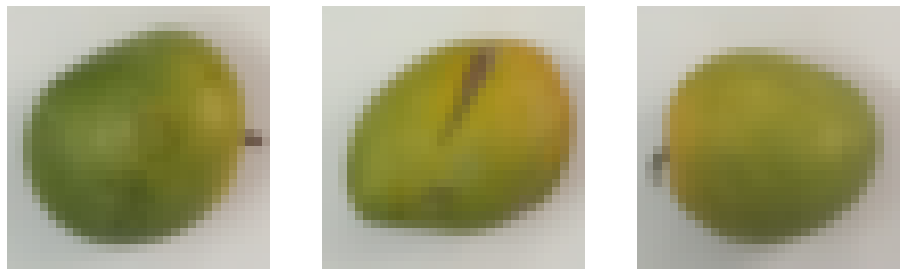

In [5]:
rn = randint(0, 200)
print (rn)
img_1 = class1[rn]
img_2 = class2[rn]
img_3 = class3[rn]    
show_row_of_gray_images(16, img_1, img_2, img_3)

### Aumentamos por un factor f el número de datos de cada clase

In [6]:
f = 10
class1_augmeted = np.zeros([n * f, h, w, 3])
class2_augmeted = np.zeros([n * f, h, w, 3])
class3_augmeted = np.zeros([n * f, h, w, 3])
t1 = np.zeros(n * f)
t2 = np.zeros(n * f)
t3 = np.zeros(n * f)

for i in range(n * f):
    rn = randint(0, n-1)
    img = class1[rn]
    new_img = data_augmentation(img)
    class1_augmeted [i] = new_img
    t1[i] = 1
    
    rn = randint(0, n-1)
    img = class2[rn]
    new_img = data_augmentation(img)
    class2_augmeted [i] = new_img
    t2[i] = 2
    
    rn = randint(0, n-1)
    img = class3[rn]
    new_img = data_augmentation(img)
    class3_augmeted [i] = new_img
    t3[i] = 0


#### Se imprimen tres imágenes para comprobar que las transformaciones han salido bien

324
1784
328


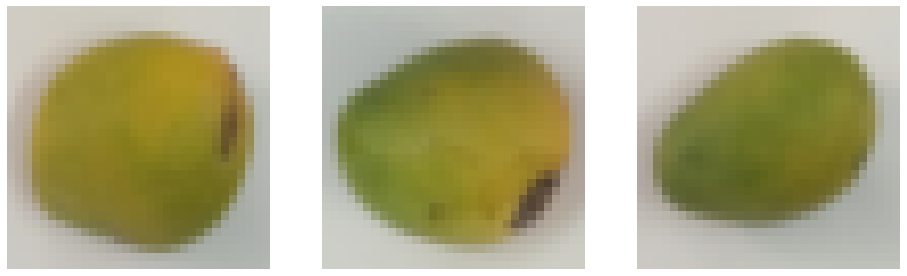

In [7]:
# Se imprimen tres imágenes aleatorias de los datos aumentados para comprobar que funciona    
rn = randint(0, 2000)
img_1 = class1_augmeted[rn]
print (rn)
rn = randint(0, 2000)
print (rn)
img_2 = class2_augmeted[rn]
rn = randint(0, 2000)
print (rn)
img_3 = class3_augmeted[rn]  
show_row_of_gray_images(16, img_1, img_2, img_3)

#### Conformación del set de datos y declaración de las métricas de análsis:

In [8]:
CV = 20
# Se define el conjunto de datos de entrenamiento
X = np.zeros([f*n*3,h*w*3])
X[0:2000] = class3_augmeted.reshape(f*n,h*w*3)
X[2000:4000] = class1_augmeted.reshape(f*n,h*w*3)
X[4000:6000] = class2_augmeted.reshape(f*n,h*w*3)

# Se definen las etiquetas de las clases
t = np.zeros(f*n*3)
t[0:2000] = t3
t[2000:4000] = t1
t[4000:6000] = t2

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3,shuffle=True)

scoring = ['recall_macro', 'precision_micro', 'recall_micro', 'f1_macro','accuracy']

#### Importamos datos de modelos anteriores

In [35]:
%store -r scoresLDA scoresKNN scoresRF

#### Se importa la red CNN VGG16 para utilizar su arquitectura y conocimento para resolver nuestro problema 

In [9]:
from keras import applications
from keras.models import Sequential
from keras.applications import vgg16
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
# include top should be False to remove the softmax layer
pretrained_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

#### Se procesan las imágenes utilizando la estructura y los pesos de la red pre-entrenada

In [10]:
# extract train and val features
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size=0.3, shuffle=True)
vgg_features_train = pretrained_model.predict(X_train.reshape(len(X_train),IMG_SIZE,IMG_SIZE,3))
vgg_features_val = pretrained_model.predict(X_val.reshape(len(X_val),IMG_SIZE,IMG_SIZE,3))

In [11]:
# OHE target column)
train_target = tf.keras.utils.to_categorical(t_train)
val_target = tf.keras.utils.to_categorical(t_val)
test_target = tf.keras.utils.to_categorical(t_test)
accuracy = []
recall = []
specificity = []
precision = []
f1_score = []
au_curve = []
model = []
epoc = []
batch = []


#### Se añaden las capas finales de la red

In [12]:
modelCNN = Sequential()
modelCNN.add(Flatten(input_shape=(1,1,512)))
modelCNN.add(Dense(100, activation='relu'))
modelCNN.add(Dropout(0.5))
modelCNN.add(BatchNormalization())
modelCNN.add(Dense(3, activation='softmax'))
# compile the model
modelCNN.compile(optimizer='adam', metrics=['accuracy',
                                            tf.keras.metrics.Recall(),
                                            tf.keras.metrics.TrueNegatives(),
                                            tf.keras.metrics.FalsePositives(), 
                                            tf.keras.metrics.Precision(),
                                            tf.keras.metrics.AUC()], loss='categorical_crossentropy')
modelCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 52,003
Trainable params: 51,803
Non-trainable params: 200
________________________________________________

#### Finalmente se realiza la clasificación utilizando las capas finales de nuestra red

In [13]:
# train model using features generated from VGG16 model
epochs = 100
batch_size = 50
history = (modelCNN.fit(vgg_features_train, train_target, epochs=100, batch_size=50, validation_data=(vgg_features_val, val_target)))

Epoch 1/100
59/59 [==============================] - 3s 26ms/step - loss: 0.9534 - accuracy: 0.5493 - recall: 0.4639 - true_negatives: 4963.0000 - false_positives: 917.0000 - precision: 0.5980 - auc: 0.7459 - val_loss: 0.9147 - val_accuracy: 0.5294 - val_recall: 0.2635 - val_true_negatives: 2325.0000 - val_false_positives: 195.0000 - val_precision: 0.6300 - val_auc: 0.7771
Epoch 2/100
59/59 [==============================] - 0s 4ms/step - loss: 0.7385 - accuracy: 0.6636 - recall: 0.5687 - true_negatives: 5212.0000 - false_positives: 668.0000 - precision: 0.7145 - auc: 0.8454 - val_loss: 0.8490 - val_accuracy: 0.7468 - val_recall: 0.2048 - val_true_negatives: 2499.0000 - val_false_positives: 21.0000 - val_precision: 0.9247 - val_auc: 0.9037
Epoch 3/100
59/59 [==============================] - 0s 4ms/step - loss: 0.6737 - accuracy: 0.7014 - recall: 0.6112 - true_negatives: 5258.0000 - false_positives: 622.0000 - precision: 0.7429 - auc: 0.8744 - val_loss: 0.7967 - val_accuracy: 0.7325 - 

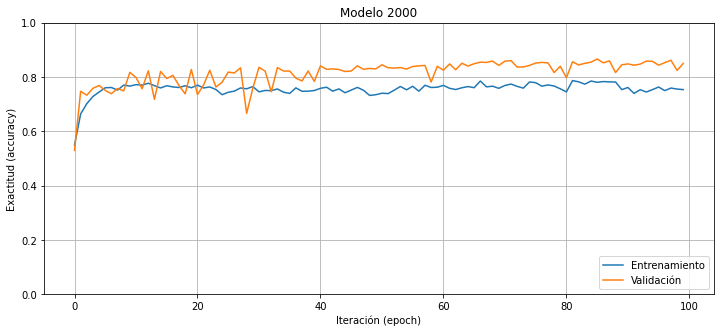

In [14]:
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label = 'Validación')
plt.xlabel('Iteración (epoch)')
plt.ylabel('Exactitud (accuracy)')
plt.ylim([0, 1])
plt.grid()
plt.title('Modelo '+str(i+1))
plt.legend(loc='lower right')

In [15]:
vgg_features_test = pretrained_model.predict(X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3))
test_loss, test_acc, test_recall, true_neg, false_pos, test_prec, test_auc = modelCNN.evaluate(vgg_features_test,  test_target, verbose=0)
spec = true_neg/(true_neg + false_pos)
f1_s = 2 * test_recall * test_prec / (test_recall + test_prec)
print('Accuray (test)', test_acc)
print("Recall: ", test_recall)
print("Specifity: ", spec)
print("Precision: ", test_prec)
print("f1-score: ", f1_s)
print("AUC: ", test_auc)


Accuray (test) 0.8577777743339539
Recall:  0.8533333539962769
Specifity:  0.9336111111111111
Precision:  0.8653520941734314
f1-score:  0.859300700654796
AUC:  0.9718661904335022


In [16]:
model.append(pretrained_model.name)
epoc.append(epochs)
batch.append(batch_size)
accuracy.append(round(test_acc,2))
recall.append(round(test_recall,2))
specificity.append(round(spec,2))
precision.append(round(test_prec,2))
f1_score.append(round(f1_s,2))
au_curve.append(round(test_auc,2))

test_data = {'model':model,
        'epochs': epoc,
        'batch_size': batch,
        'accuracy': accuracy,
        'recall': recall,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score,
        'auc': au_curve,
        }

df = pd.DataFrame(test_data)
df.to_excel("./informe/tables/CNN.xlsx") 
print(df)

   model  epochs  batch_size  accuracy  recall  specificity  precision  \
0  vgg16     100          50      0.86    0.85         0.93       0.87   

   f1_score   auc  
0      0.86  0.97  


In [17]:
vgg_features_test = pretrained_model.predict(X_test.reshape(len(X_test),IMG_SIZE,IMG_SIZE,3))

In [18]:
Clases=['Clase extra','Clase I','Clase II']
t_pred = []
for i in range(0,len(vgg_features_test)):
    t_pred.append(np.argmax(modelCNN.predict(vgg_features_test[i:i+1])))

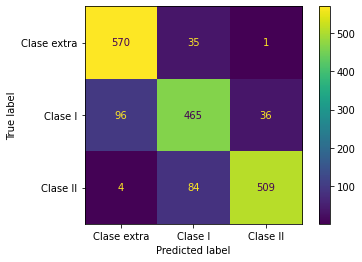

In [33]:
#tf.math.confusion_matrix(t_test, t_pred)

cm = confusion_matrix(t_test, t_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=Clases)
disp.plot()


#### Se muestra un diagrama de cajas con los resultados  finales de los modelos. 

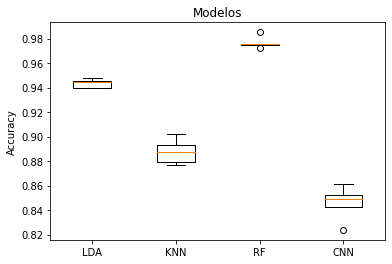

In [40]:

data = [scoresLDA['test_accuracy'], scoresKNN['test_accuracy'], scoresRF['test_accuracy'],history.history['val_accuracy'][-5:] ]
fig7, ax = plt.subplots()
ax.set_title('Modelos')
ax.set_ylabel('Accuracy')
ax.boxplot(data,labels=['LDA', 'KNN', 'RF','CNN']);

#### Contraste de hipótesis:

Primero se muestran los resultados obtenidos aplicando el test de [Kruskall-Wallis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) y el test de [Anova](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html). Si se rechaza la hipótesis, entonces se puede afirmar que los modelos son diferentes y, posteriormente, se aplican dos test de comparación múltiple mediante el uso de la clase [MultiComparison](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html). Estos métodos comprueban si hay diferencias significativas con un p<0.05, corrigiendo el hecho de que se están haciendo múltiples comparaciones que normalmente aumentarían la probabilidad de que se identifique una diferencia significativa. Un resultado de "reject = true" significa que se ha observado una diferencia significativa:
- Método de Tukey. Se emplea para ello la función [tukeyhsd](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd.html#statsmodels.sandbox.stats.multicomp.MultiComparison.tukeyhsd).
- Método de Holm-Bonferroni. Se emplea para ello la función [allpairtest](https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest.html#statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest)

In [42]:
alpha = 0.05
F_statistic, pVal = stats.kruskal(scoresLDA['test_accuracy'], scoresKNN['test_accuracy'], scoresRF['test_accuracy'],history.history['val_accuracy'][-5:])
print ('p-valor KrusW:', pVal)
if pVal <= alpha:
    print('Rechazamos la hipótesis: los modelos son diferentes\n')

else:
    print('Aceptamos la hipótesis: los modelos son iguales')

p-valor KrusW: 0.0004647475402630703
Rechazamos la hipótesis: los modelos son diferentes

